Giá trị F1 (trung bình thời gian tàu ở cảng): 54269.82903456688
Giá trị F2 (trung bình tổng quãng đường vận chuyển container do lệch bến): 576.9845
Giá trị F3 (tổng chi phí chờ và trễ): 312010.0016593933
F = 9535.566192943183
Iter 1: Best = 172.41 | Avg = 177.36 | Worst = 184.03
Iter 6: Best = 171.73 | Avg = 176.79 | Worst = 185.41
Iter 11: Best = 171.48 | Avg = 176.43 | Worst = 182.25
Iter 16: Best = 171.48 | Avg = 176.42 | Worst = 182.67
Early convergence at iteration 17

=== Optimization Summary ===
Total iterations: 100
Best solution found at iteration: 16
Best fitness value: 171.4829
Execution time: 0.54 seconds

Best solution details:
Vessel-Berth assignments: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
Crane allocations: [1, 2, 1, 3, 4, 5, 1, 1, 4, 2, 2, 3, 2, 4, 4, 5, 3, 2, 3, 2]
Start times: ['1743390000.01', '1743411600.27', '1743435000.25', '1743505200.37', '1743525000.16', '1743634800.25', '1743759000.20', '1743786000.04', '1743854400.05', '1743946200.26', 

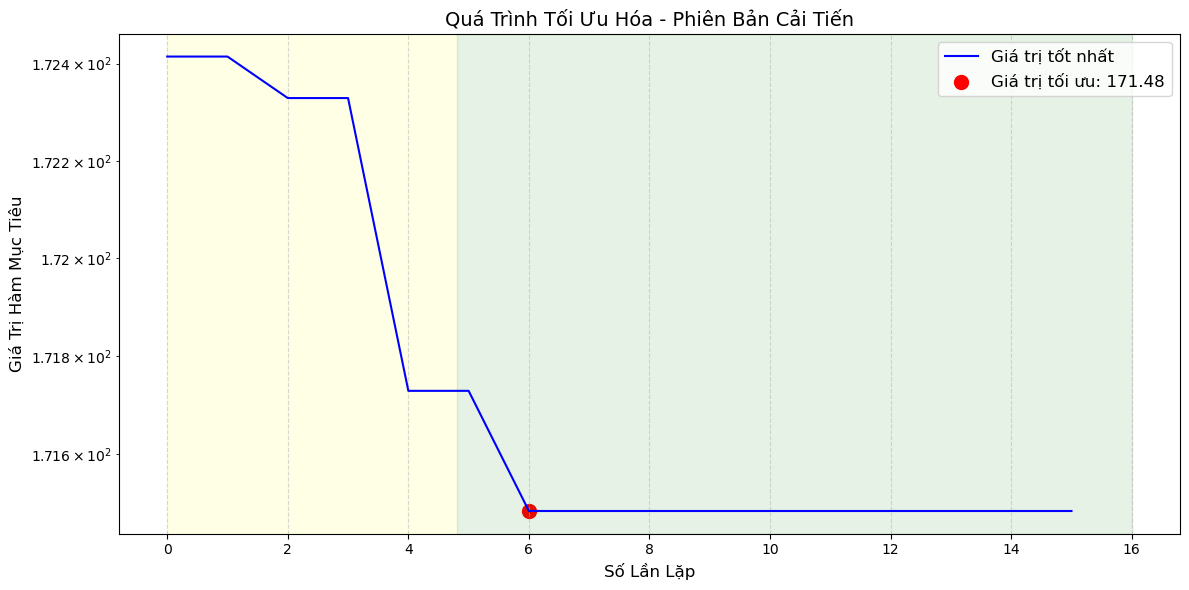

C:\Users\minhv\AppData\Local\Temp\ipykernel_1456\246920579.py:932: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\minhv\anaconda3\envs\pytorch-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


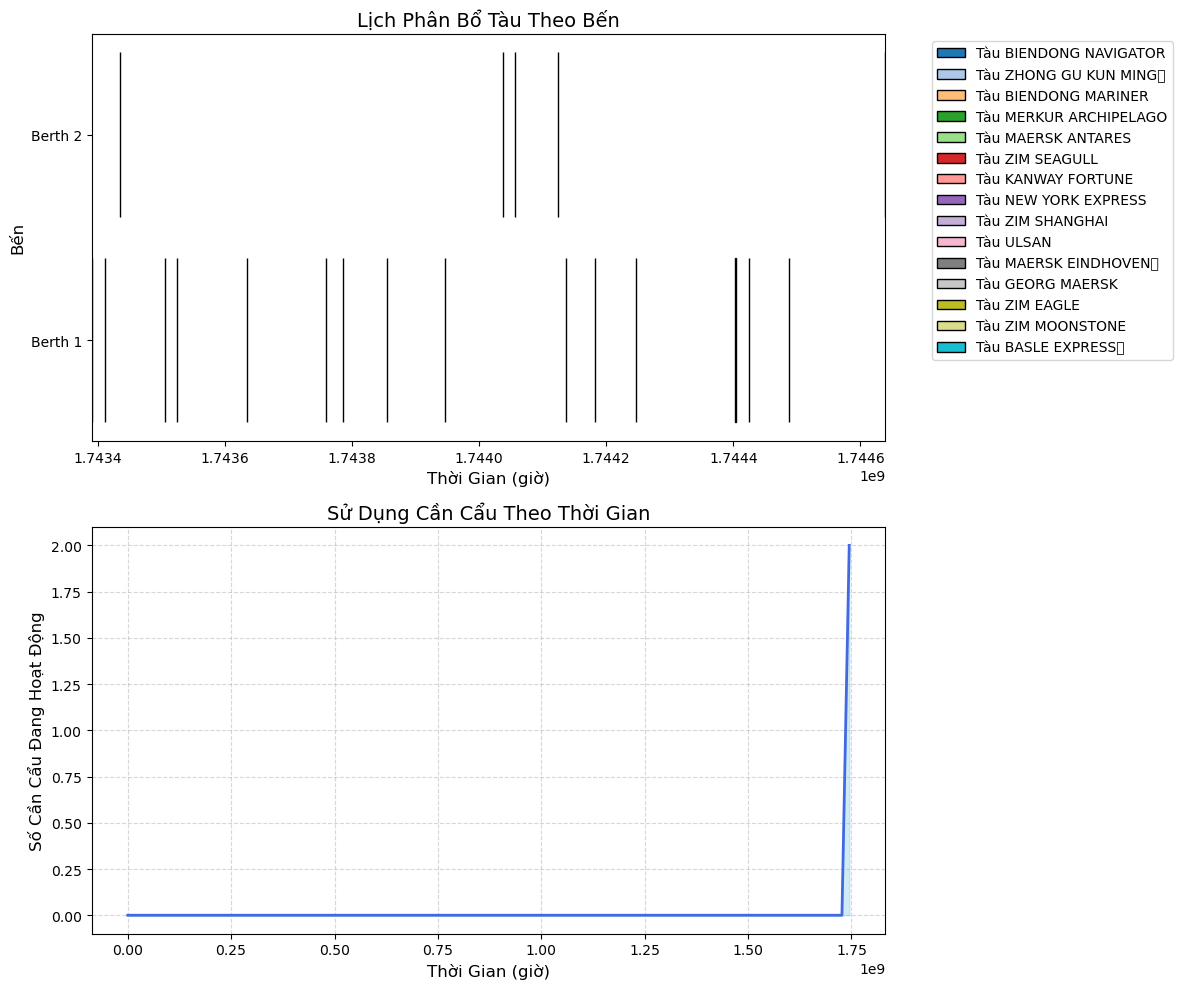

In [9]:
import time
import numpy as np
from datetime import datetime, timedelta
import math
from copy import deepcopy
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


InputVariables = pd.read_excel(r'E:\KLTN_DU\Source\Data\Data for Coding.xlsx', sheet_name='Input Variables')
VS = pd.read_excel(r'E:\KLTN_DU\Source\Data\Data for Coding.xlsx', sheet_name='Vessel Schedule')
ChannelBerth = pd.read_excel(r'E:\KLTN_DU\Source\Data\Data for Coding.xlsx', sheet_name='Channel-Berth')
Tidal = pd.read_excel(r'E:\KLTN_DU\Source\Data\Data for Coding.xlsx', sheet_name='Tidal')
VesselSchedule = VS[:20]
LengthSave = pd.read_excel(r'E:\KLTN_DU\Source\Data\Data for Coding.xlsx', sheet_name='Khoảng cách an toàn')
LSd = LengthSave['Khoảng cách d giữa các tàu (m)'].tolist()
LSe = LengthSave['Khoảng cách e giữa tàu và điểm cuối đoạn thẳng tuyến bến (m)'].tolist()

TG0 = InputVariables.iloc[0, 2] #Thời gian cố định để tàu di chuyển qua kênh
W = InputVariables.iloc[1, 2] #Độ dài mỗi khung thời gian thủy triều cao/thấp
R = InputVariables.iloc[2, 2] #Một số nguyên đủ lớn để ràng buộc
M = InputVariables.iloc[3, 2] #Tổng số xe tải có thể sử dụng
CE0 = float(InputVariables.iloc[4, 2]) #thời gian để 1 cần cẩu bốc dỡ 1 container (giờ)
CF0 = float(InputVariables.iloc[5, 2]) #thời gian để 1 cần cẩu bốc dỡ 1 container (giờ)
vh = np.random.normal(loc=25, scale=4) #Tốc độ xe tải khi không tải
vl = np.random.normal(loc=18, scale=3) #Tốc độ khi xe container quá tải
n_ = InputVariables.iloc[9, 2] #Mức tiêu thụ nhiên liệu khi chạy không tải
E1 = float(InputVariables.iloc[10, 2]) #Hệ số phát thải carbon của xe tải
E2 = InputVariables.iloc[11, 2] #Hệ số chuyển đổi điện năng sang khí thải carbon
lambda1 = InputVariables.iloc[12, 2] #Mức tiêu thụ năng lượng khi cần cẩu làm việc
lambda2 = InputVariables.iloc[13, 2] #Mức tiêu thụ năng lượng khi cần cẩu di chuyển giữa các vị trí
Channel = InputVariables.iloc[14, 2] #Kênh
V = VesselSchedule['Vessel Name'].tolist() #Vessel
TAi = VesselSchedule['TOi (Estimated Time of Arrival)'].tolist() # Thời gian dự kiến tàu đến
TFi = VesselSchedule['TFi (Estimated Time of departure)'].tolist() # Thời gian dự kiến tàu đi
TWi = VesselSchedule['TWi (Maximum waiting time, hour)'].tolist() # Thời gian chờ tối đa của tàu
VLi = VesselSchedule['VLi (Length, m)'].tolist() #VLi (Chiều dài tàu i) (mét)
VDi = VesselSchedule['VDi (Draft, m)'].tolist() #VDi (Mớn nước của tàu i) (mét)
VEi = VesselSchedule['VEi (Total container)'].tolist() #VEi (Số lượng container tàu chở)
VCmi = VesselSchedule['VCmi (Lower limit of quay cranes)'].tolist() #VCmi (Số cần cẩu tối thiểu cho tàu i ) (chiếc)
VCMi = VesselSchedule['VCMi (Upper limit of quay cranes)'].tolist() #VCMi (Số cần cẩu tối đa cho tàu i) (chiếc)
lst1 = [float(x) for x in VesselSchedule['Di1 (Distance vessel i at berth 1 - target \nyard, km)']]
lst2 = [float(x) for x in VesselSchedule['Di2 (Distance vessel i at berth 2 - target \nyard, km)']]
Dij = [[l1, l2] for l1, l2 in zip(lst1, lst2)]
B = ChannelBerth['ID bến'].tolist() #Berth
BLj = ChannelBerth['BLj (Chiều dài của bến j ) (mét)'].tolist() #BLj (Chiều dài của bến j ) (mét)
BDj = ChannelBerth['BDj (Mớn nước tại bến j ) (mét)'].tolist() #BDj (Mớn nước tại bến j ) (mét)
Tt = [Tidal.iloc[0, 2], Tidal.iloc[2, 2]] #Khung thoi gian thuy trieu cao
Uiu = False #1 nếu tàu i đi vào kênh ở vị trí u_th khi thủy triều dâng else 0
Viu = False #1 nếu tàu i đi ra khỏi kênh ở phía u_th khi thủy triều dâng else 0
w1 = InputVariables.iloc[15, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
w2 = InputVariables.iloc[16, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
w3 = InputVariables.iloc[17, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
e = InputVariables.iloc[18, 2] #Hằng số logarit
kTA = InputVariables.iloc[19, 2] # Hệ số tính toán thời gian chờ Erlang
l1 = np.random.normal(loc=15.75, scale=1.25) #Tải trọng của xe khi không tải 
l2 = np.random.normal(loc=33.5, scale=1.5) #Tải trọng của xe khi đầy tải 
T = [i for i in range(1,25)]
C = 6 #Crane
Y = [i for i in range(1, 46)] #Truck
xijk = [] #1 nếu tàu i phục vụ theo trình tự k tại bến j else 0
qitn = [] #1 nếu cần cẩu cầu cảng n phục vụ cho tàu i trong thời gian t else 0
u_iu = [] # Biến nhị phân biểu thị khung thời gian tàu có thể vào
v_iu = [] # Biến nhị phân biểu thị khung thời gian tàu có thể ra
VCi = VesselSchedule['VCmi (Lower limit of quay cranes)'].to_list() #Số lượng cần cẩu được phân công cố định cho tàu
VCit = VesselSchedule['VCMi (Upper limit of quay cranes)'].to_list() #Số lượng cần cẩu phục vụ
TWi = [float(val) for val in TWi]
x = []
for i in range(len(TWi)):
    x.append(np.random.normal(loc=float(TWi[i]) / 2, scale=float(TWi[i]) / 2))
    
u_TA = 1.0 / (sum(x) / len(x))
TH1 = [i / vh for i in lst1] #Thời gian xe tải rỗng ddi từ bến 1 
TH2 = [i / vh for i in lst2] #Thời gian xe tải rỗng ddi từ bến 2
TL1 = [i / vl for i in lst1] #Thời gian vận chuyển hàng hóa nặng bằng xe tải từ bến 1
TL2 = [i / vl for i in lst2] #Thời gian vận chuyển hàng hóa nặng bằng xe tải từ bến 2
VmL = [] #nhóm tàu lớn đang cập cảng
CKnt = [] #tập hợp số lượng xe tải phục vụ cẩu tại bến n thời điểm t 
delTA = []  # Độ lệch thời gian dựa trên Erlang   # Thời gian đến thực tế sau khi cộng độ lệch
TEi = [] #Thời gian kết thúc bốc/dỡ tàu i.
TDTS = []
VO = [] #tập hợp các thứ tự của tàu thuyền vào cảng
VB = [] #Bến tàu i sẽ cập
VC = [] #Số cần cẩu phân bổ cho tàu i
VK = [] #Số xe tải phân bổ cho tàu i
dtb = 500 #Dung tích bình xăng
def calculate_pvl(v, l):
    a = 0.02
    b = -1.67
    c = 0.46
    d = 0.03
    e = 51.17
    return a * v * v + b * v + c * l + d * v * l + e
Dl = float(dtb) / calculate_pvl(vh, l1) * 100 #Tổng quãng đường xe tải đi được khi không có hàng dung tích bình 500l
Dk = float(dtb) / calculate_pvl(vl, l2) * 100#Tổng quãng đường xe tải chở hàng nặng đã đi
tn_ = float(Dl) / vh #Tổng thời gian xe tải chạy không tải tiêu thụ nhiên liệu
def calculate_con13():
    #Sum VCit: tong so can cau phan bo trong suot qua trinh -> = VCMi
    for i in range(len(VEi)):
        TDTS.append(float(VEi[i])/(CE0 * VCit[i]))
calculate_con13()

def convert_time_to_float(time_val):
    if isinstance(time_val, str):
        dt = datetime.strptime(time_val, "%d/%m/%Y %H:%M:%S")
    elif isinstance(time_val, pd.Timestamp) or isinstance(time_val, datetime):
        dt = time_val
    else:
        raise ValueError(f"Unsupported type: {type(time_val)}")
    epoch = datetime(1970, 1, 1)
    delta = dt - epoch
    return delta.total_seconds()
TO_float = [convert_time_to_float(t) for t in TAi]
def calculate_fErlang():
    for i in range(len(x)):
        fxku_ = (pow(u_TA * x[i], kTA - 1) * np.exp(-u_TA * x[i]))
        fxku_ /= math.factorial(kTA - 1)
        delTA.append(fxku_)
    return delTA
def calculate_TA(TO_float, delTAi):
    lst = [TO_float[i] + delTAi[i] for i in range(len(TO_float))]
    return lst
calculate_fErlang()
TAi = calculate_TA(TO_float, delTA)
TF_float = [convert_time_to_float(t) for t in TFi]
for i in range(len(TF_float)):
    TEi.append(TF_float[i] - TWi[i])
TAi_float = [float(i) for i in TAi]
TB = [TAi_float[i] + 0.25 for i in range(len(TAi_float))]
TBi = [TB[i] + TWi[i] for i in range(len(TB))] #Thời điểm tàu i đã vào cảng
TSi = [TBi[i] + float(10)/60 for i in range(len(TBi))]     #Thời gian bắt đầu công việc cho tàu
TV = TSi #Thời gian bắt đầu hỗ trợ từ cần cẩu lân cận cho tàu = TSi
TD = [TDTS[i] + TSi[i] for i in range(len(TDTS))]
delVCit = [VCMi[i] - VCmi[i] for i in range(len(VCMi))] # Số lượng cần cẩu di chuyển từ bến lân cận để hỗ trợ tàu i tại thời điểm t = VCMi - VCmi
def float_to_datetime(float_time):
    epoch = datetime(1970, 1, 1)
    return epoch + timedelta(seconds=float_time)
TDi = Dij
TQi = [i - 0.167 for i in TF_float]
alpha = 1000
gamma = 1500
VL = 15
VD = 16.5
LSd = LengthSave['Khoảng cách d giữa các tàu (m)'].tolist()
LSe = LengthSave['Khoảng cách e giữa tàu và điểm cuối đoạn thẳng tuyến bến (m)'].tolist()

def calculate_F1(TFi, TAi):
    """
    Tính giá trị hàm mục tiêu F1: trung bình thời gian tàu ở cảng.
    Args:
        TFi: List hoặc mảng thời gian rời cảng của các tàu (float, cùng đơn vị với TAi)
        TAi: List hoặc mảng thời gian đến cảng của các tàu (float)
    Returns:
        F1: Trung bình thời gian tàu ở cảng
    """
    TFi = np.array(TFi, dtype=float)
    TAi = np.array(TAi, dtype=float)
    v = len(TFi)
    F1 = np.sum(TFi - TAi) / v
    return F1
F1 = calculate_F1(TF_float, TAi)
print("Giá trị F1 (trung bình thời gian tàu ở cảng):", F1)

def calculate_F2(VEi, TDi):
    """
    Tính giá trị hàm mục tiêu F2: trung bình tổng quãng đường vận chuyển container do lệch bến.
    Args:
        VEi: List hoặc mảng số container của các tàu (float)
        TDi: List hoặc mảng khoảng cách giữa bến thực tế và bến ưu tiên của các tàu (float)
    Returns:
        F2: Trung bình tổng quãng đường vận chuyển container do lệch bến
    """
    VEi = np.array(VEi, dtype=float)
    TDi = np.array(TDi, dtype=float)
    v = len(VEi)
    F2 = np.sum(VEi * TDi) / v
    return F2
berth_index = [0 for _ in range(len(VEi))]  # Tất cả tàu vào bến 0
TDi_1d = [TDi[i][berth_index[i]] for i in range(len(VEi))]
F2 = calculate_F2(VEi, TDi_1d)
print("Giá trị F2 (trung bình tổng quãng đường vận chuyển container do lệch bến):", F2)

def calculate_F3(TBi, TAi, TFi, TQi, alpha, gamma):
    """
    Tính giá trị hàm mục tiêu F3: tổng chi phí chờ và trễ của tàu.
    Args:
        TBi: List thời gian tàu i cập bến (float)
        TAi: List thời gian tàu i đến cảng (float)
        TFi: List thời gian tàu i rời cảng (float)
        TQi: List thời gian dự kiến tàu i rời cảng (float)
        alpha: Đơn giá thời gian chờ tàu cập cảng
        gamma: Đơn giá thời gian tàu rời cảng trễ
    Returns:
        F3: Tổng chi phí chờ và trễ của tất cả tàu
    """
    TBi = np.array(TBi, dtype=float)
    TAi = np.array(TAi, dtype=float)
    TFi = np.array(TFi, dtype=float)
    TQi = np.array(TQi, dtype=float)
    F3 = np.sum(alpha * (TBi - TAi) + gamma * (TFi - TQi))
    return F3

F3 = calculate_F3(TBi, TAi, TF_float, TQi, alpha, gamma)
print("Giá trị F3 (tổng chi phí chờ và trễ):", F3)
lam1 = 0.0001
lam2 = 1
lam3 = 0.1
F = w1 * lam1 * F1 + w2 * lam2 * F2 + w3 * lam3 * F3
print("F =", F)





import numpy as np
import random
from copy import deepcopy
from datetime import datetime, timedelta
import math
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

class ImprovedSSA:
    def __init__(self, num_sparrows, dim, max_iter, problem_params):
        # Kiểm tra và chuẩn hóa dữ liệu đầu vào
        self.validate_inputs(problem_params)
        
        self.num_sparrows = num_sparrows
        self.dim = dim
        self.max_iter = max_iter
        self.problem_params = self.normalize_params(problem_params)
        
        # Tham số điều chỉnh
        self.pd = 0.3  # Tỷ lệ chim cảnh giác
        self.st = 0.8  # Ngưỡng an toàn
        self.alpha = 0.8  # Hệ số điều chỉnh
        
        self.adaptive_pd = True  # Cho phép điều chỉnh động pd
        self.initial_pd = 0.3
        self.final_pd = 0.1
        
        # Khởi tạo quần thể với cơ chế dự phòng
        self.population = self.initialize_population_with_fallback()
        if len(self.population) == 0:
            raise ValueError("Không thể khởi tạo bất kỳ cá thể hợp lệ nào. Vui lòng kiểm tra lại ràng buộc đầu vào.")
            
        self.best_solution = None
        self.best_fitness = float('inf')
        
        # Theo dõi lịch sử
        self.fitness_history = []
        self.diversity_history = []
    
    def initialize_population_with_fallback(self):
        """Khởi tạo quần thể với cơ chế dự phòng nếu không đạt yêu cầu"""
        try:
            # Thử khởi tạo với số lần thử lớn hơn
            population = self.initialize_population(max_attempts=500)
            if len(population) >= self.num_sparrows * 0.8:  # Chấp nhận 80% số lượng
                return population[:self.num_sparrows]
                
            # Nếu không đủ, thử phương pháp đơn giản hơn
            print("Cảnh báo: Sử dụng phương pháp khởi tạo đơn giản hơn do ràng buộc quá chặt")
            return self.initialize_simple_population()
        except Exception as e:
            print(f"Cảnh báo khi khởi tạo: {str(e)}")
            return self.initialize_simple_population()
    
    def initialize_simple_population(self):
        """Khởi tạo quần thể đơn giản hơn, bỏ qua một số ràng buộc phức tạp"""
        population = []
        num_ships = len(self.problem_params['V'])
        num_berths = len(self.problem_params['B'])
        
        for _ in range(self.num_sparrows):
            solution = {'VB': [], 'VC': [], 'VK': [], 'TS': [], 'TE': []}
            
            # Phân bổ bến đơn giản - chỉ kiểm tra mớn nước
            for i in range(num_ships):
                valid_berths = [j for j in range(num_berths) 
                              if self.problem_params['VDi'][i] <= self.problem_params['BDj'][j]]
                solution['VB'].append(random.choice(valid_berths) if valid_berths else 0)
                
                # Phân bổ cần cẩu tối thiểu
                solution['VC'].append(self.problem_params['VCmi'][i])
                solution['VK'].append(1)  # Số xe tải tối thiểu
            
            # Tính toán thời gian đơn giản
            for i in range(num_ships):
                service_time = self.problem_params['VEi'][i] / (solution['VC'][i] * self.problem_params['CE0'])
                solution['TS'].append(self.problem_params['TAi'][i])
                solution['TE'].append(self.problem_params['TAi'][i] + service_time)
            
            population.append(solution)
        
        return population
    
    def validate_inputs(self, params):
        """Kiểm tra tính hợp lệ của dữ liệu đầu vào"""
        required_keys = ['B', 'V', 'VCmi', 'VCMi', 'VDi', 'BDj', 'VLi', 'BLj', 
                        'M', 'w1', 'w2', 'w3', 'alpha', 'gamma', 'CE0', 'VEi', 
                        'TAi', 'Dij', 'TQi']
        for key in required_keys:
            if key not in params:
                raise ValueError(f"Thiếu tham số bắt buộc: {key}")
                
        if len(params['V']) != len(params['VDi']):
            raise ValueError("Số lượng tàu không khớp với dữ liệu mớn nước")
            
        # Kiểm tra xem có ít nhất một bến phù hợp cho mỗi tàu
        # Kiểm tra mỗi tàu có ít nhất một bến phù hợp
        for i, vessel in enumerate(params['V']):
            valid_berths = [j for j, b in enumerate(params['B']) 
                          if (params['VDi'][i] <= params['BDj'][j] and 
                              params['VLi'][i] <= params['BLj'][j])]
            if not valid_berths:
                print(f"Lỗi: Tàu {vessel} (VDi={params['VDi'][i]}, VLi={params['VLi'][i]}) không có bến phù hợp")
                return False
        return True
    
    def initialize_population(self, max_attempts=100):
        population = []
        num_ships = len(self.problem_params['V'])
        num_berths = len(self.problem_params['B'])

        for _ in range(self.num_sparrows):
            solution = {'VB': [], 'VC': [], 'VK': [], 'TS': [], 'TE': []}
            valid = True

            # Phân bổ bến và cần cẩu
            for i in range(num_ships):
                # Tìm bến phù hợp
                valid_berths = [
                    j for j in range(num_berths)
                    if (self.problem_params['VDi'][i] <= self.problem_params['BDj'][j] and
                        self.problem_params['VLi'][i] <= self.problem_params['BLj'][j])
                ]

                if not valid_berths:
                    valid = False
                    break

                solution['VB'].append(random.choice(valid_berths))
                solution['VC'].append(random.randint(
                    self.problem_params['VCmi'][i],
                    self.problem_params['VCMi'][i]))
                solution['VK'].append(random.randint(1, 5))

            if not valid:
                continue
            
            # Tính toán thời gian
            if self.calculate_times(solution):
                population.append(solution)

        return population
    
    def calculate_times(self, solution):
        """Tính toán thời gian bắt đầu/kết thúc đảm bảo ràng buộc"""
        num_ships = len(self.problem_params['V'])
        berth_schedules = {b: [] for b in range(len(self.problem_params['B']))}

        # Sắp xếp tàu theo thời gian đến để xử lý
        ship_order = sorted(range(num_ships), key=lambda x: self.problem_params['TAi'][x])

        for i in ship_order:
            # Đảm bảo berth là số nguyên
            berth = int(round(solution['VB'][i]))
            qc = solution['VC'][i]
            service_time = self.problem_params['VEi'][i] / (qc * self.problem_params['CE0'])

            # Tìm thời điểm bắt đầu sớm nhất có thể
            earliest_start = self.problem_params['TAi'][i]

            # Kiểm tra lịch trình của bến
            if berth in berth_schedules and berth_schedules[berth]:
                last_job = max(berth_schedules[berth], key=lambda x: x[1])
                earliest_start = max(earliest_start, last_job[1])

            start_time = earliest_start
            end_time = start_time + service_time

            # Kiểm tra thời gian chờ tối đa
            max_wait = self.problem_params.get('TWi', [float('inf')]*num_ships)[i]
            if start_time - self.problem_params['TAi'][i] > max_wait:
                return False

            solution['TS'].append(start_time)
            solution['TE'].append(end_time)
            berth_schedules[berth].append((start_time, end_time))

        # Đảm bảo thứ tự TS, TE đúng với thứ tự tàu ban đầu
        solution['TS'] = [solution['TS'][ship_order.index(i)] for i in range(num_ships)]
        solution['TE'] = [solution['TE'][ship_order.index(i)] for i in range(num_ships)]

        return True

    # ... (giữ nguyên các phương thức khác như evaluate_fitness, update_positions, v.v.)
    def validate_inputs(self, params):
        """Kiểm tra tính hợp lệ của dữ liệu đầu vào"""
        required_keys = ['B', 'V', 'VCmi', 'VCMi', 'VDi', 'BDj', 'VLi', 'BLj', 
                        'M', 'w1', 'w2', 'w3', 'alpha', 'gamma', 'CE0', 'VEi', 
                        'TAi', 'Dij', 'TQi']
        for key in required_keys:
            if key not in params:
                raise ValueError(f"Thiếu tham số bắt buộc: {key}")
                
        if len(params['V']) != len(params['VDi']):
            raise ValueError("Số lượng tàu không khớp với dữ liệu mớn nước")
    def calculate_F1(self, individual):
        """Tính F1: trung bình thời gian tàu ở cảng (dựa trên TS, TE thực tế)"""
        total_time = 0
        for i in range(len(self.problem_params['V'])):
            # Sử dụng thời gian thực tế từ solution
            total_time += individual['TE'][i] - individual['TS'][i]
        return total_time / len(self.problem_params['V'])

    def calculate_F2(self, individual):
        """Tính F2: trung bình tổng quãng đường vận chuyển"""
        total_distance = 0
        for i in range(len(self.problem_params['V'])):
            berth = int(individual['VB'][i])
            # Kiểm tra chỉ số bến có hợp lệ với Dij không
            if berth >= len(self.problem_params['Dij'][i]):
                return 1e9  # Phạt nặng nếu chỉ số bến không hợp lệ
            total_distance += self.problem_params['VEi'][i] * self.problem_params['Dij'][i][berth]
        return total_distance / len(self.problem_params['V'])

    def calculate_F3(self, individual):
        """Tính F3: tổng chi phí chờ và trễ (dựa trên TS, TE thực tế)"""
        total_cost = 0
        for i in range(len(self.problem_params['V'])):
            # Sử dụng thời gian thực tế từ solution
            start_time = individual['TS'][i]
            end_time = individual['TE'][i]
            waiting_cost = self.problem_params['alpha'] * (start_time - self.problem_params['TAi'][i])
            delay_cost = self.problem_params['gamma'] * max(0, (end_time) - self.problem_params['TQi'][i])
            total_cost += waiting_cost + delay_cost
        return total_cost
    
    def update_followers(self):
        """Cập nhật vị trí của nhóm theo dõi"""
        for i in range(int(self.num_sparrows * 0.2), self.num_sparrows):
            vb_len = len(self.population[i]['VB'])
            if i > self.num_sparrows / 2:
                # Cập nhật theo công thức follower 1
                for d in range(vb_len):
                    self.population[i]['VB'][d] = np.random.normal() * np.exp(
                        (self.best_solution['VB'][d] - self.population[i]['VB'][d]) / (i ** 2))
            else:
                # Cập nhật theo công thức follower 2
                a = np.random.randint(-1, 2, size=vb_len)
                for d in range(vb_len):
                    self.population[i]['VB'][d] = self.best_solution['VB'][d] + abs(
                        self.population[i]['VB'][d] - self.best_solution['VB'][d]) * a[d] * 1.0
    
    def update_scouts(self):
        """Cập nhật vị trí của nhóm cảnh giác"""
        num_scouts = int(self.num_sparrows * self.pd)
        scout_indices = random.sample(range(self.num_sparrows), num_scouts)
        
        for idx in scout_indices:
            r2 = random.random()
            vb_len = len(self.population[idx]['VB'])
            if r2 < self.st:
                # Di chuyển đến vị trí tốt hơn
                for d in range(vb_len):
                    self.population[idx]['VB'][d] = self.best_solution['VB'][d] + np.random.normal() * abs(
                        self.population[idx]['VB'][d] - self.best_solution['VB'][d])
            else:
                # Di chuyển ngẫu nhiên
                for d in range(vb_len):
                    self.population[idx]['VB'][d] += np.random.normal()
    def normalize_params(self, params):
        """Chuẩn hóa các tham số đầu vào"""
        normalized = params.copy()
        
        # Chuyển đổi kiểu dữ liệu
        normalized['M'] = int(params['M'])
        normalized['VCmi'] = [int(x) for x in params['VCmi']]
        normalized['VCMi'] = [int(x) for x in params['VCMi']]
        normalized['TAi'] = [float(x) for x in params['TAi']]
        normalized['VEi'] = [float(x) for x in params['VEi']]
        
        return normalized
    def evaluate_fitness(self, solution):
        """Đánh giá độ thích nghi của giải pháp với các ràng buộc"""
        try:
            # Tính các thành phần mục tiêu
            F1 = self.calculate_F1(solution)
            F2 = self.calculate_F2(solution)
            F3 = self.calculate_F3(solution)
            
            # Tính toán penalty cho các ràng buộc vi phạm
            penalty = self.calculate_penalty(solution)
            
            # Kết hợp với trọng số
            fitness = (self.problem_params['w1'] * F1 + 
                      self.problem_params['w2'] * F2 + 
                      self.problem_params['w3'] * F3 + 
                      penalty)
            
            return fitness
            
        except Exception as e:
            print(f"Lỗi khi đánh giá: {str(e)}")
            return float('inf')
    
    def calculate_penalty(self, solution):
        """Tính toán penalty cho các ràng buộc vi phạm"""
        penalty = 0
        num_ships = len(self.problem_params['V'])
        
        # Kiểm tra ràng buộc cần cẩu liên tục (Constraint 21)
        for i in range(num_ships):
            if not self.check_crane_continuity(solution, i):
                penalty += 1000
                
        # Kiểm tra ràng buộc thời gian (Constraints 6-8, 16, 20)
        for i in range(num_ships):
            if solution['TS'][i] < solution['TE'][i-1] if i > 0 else 0:
                penalty += 500
                
        return penalty
    
    def check_crane_continuity(self, solution, ship_idx):
        """Kiểm tra ràng buộc cần cẩu liên tục cho một tàu"""
        # Giả sử solution có thông tin về vị trí cần cẩu
        # Đây là chỗ cần triển khai cụ thể theo cách bạn lưu trữ thông tin cần cẩu
        return True  # Tạm thời luôn trả về True
    def update_positions(self, iteration):
        """Cập nhật vị trí các cá thể với cơ chế thích nghi"""
        # Sắp xếp quần thể theo độ thích nghi
        sorted_pop = sorted(self.population, key=lambda x: self.evaluate_fitness(x))
        
        # Cập nhật nhóm khám phá (20% tốt nhất)
        num_explorers = int(self.num_sparrows * 0.2)
        for i in range(num_explorers):
            self.update_explorer(sorted_pop[i], iteration)
        
        # Cập nhật nhóm theo dõi (70% còn lại)
        for i in range(num_explorers, self.num_sparrows):
            self.update_followers(sorted_pop[i], i, iteration)
        
        # Cập nhật nhóm cảnh giác (ngẫu nhiên)
        self.update_scouts(iteration)
    
    def update_explorer(self, explorer, iteration):
        """Cập nhật vị trí chim khám phá"""
        adaptive_factor = 1 - (iteration / self.max_iter)
        
        for i in range(len(explorer['VB'])):
            if random.random() < self.st:
                # Khám phá hướng tốt hơn
                explorer['VB'][i] += self.alpha * adaptive_factor * random.random()
            else:
                # Khám phá ngẫu nhiên
                explorer['VB'][i] += random.normalvariate(0, 0.5 * adaptive_factor)
            
            # Đảm bảo giá trị trong phạm vi hợp lệ
            explorer['VB'][i] = max(0, min(len(self.problem_params['B'])-1, explorer['VB'][i]))
            
            # Cập nhật số cần cẩu
            if random.random() < 0.3:
                min_qc = self.problem_params['VCmi'][i]
                max_qc = self.problem_params['VCMi'][i]
                explorer['VC'][i] = random.randint(min_qc, max_qc)
    
    def repair_solution(self, solution):
        """Sửa chữa giải pháp vi phạm ràng buộc"""
        # Sửa chữa phân bổ bến - đảm bảo là số nguyên
        for i in range(len(solution['VB'])):
            # Làm tròn và ép kiểu về integer
            berth = int(round(solution['VB'][i]))
            # Giới hạn trong phạm vi bến hợp lệ
            berth = max(0, min(len(self.problem_params['B'])-1, berth))

            # Kiểm tra điều kiện mớn nước và chiều dài
            if (self.problem_params['VDi'][i] > self.problem_params['BDj'][berth] or
                self.problem_params['VLi'][i] > self.problem_params['BLj'][berth]):
                # Tìm bến phù hợp gần nhất
                valid_berths = [
                    j for j in range(len(self.problem_params['B'])) 
                    if (self.problem_params['VDi'][i] <= self.problem_params['BDj'][j] and
                        self.problem_params['VLi'][i] <= self.problem_params['BLj'][j])
                ]
                if valid_berths:
                    berth = random.choice(valid_berths)
                else:
                    berth = 0  # Mặc định về bến 0 nếu không có bến phù hợp

            solution['VB'][i] = berth

        # Sửa chữa số cần cẩu
        for i in range(len(solution['VC'])):
            solution['VC'][i] = max(self.problem_params['VCmi'][i], 
                                  min(self.problem_params['VCMi'][i], solution['VC'][i]))

        # Tính toán lại thời gian
        self.calculate_times(solution)

        return solution
    def update_explorers(self, iter):
        """Cập nhật nhóm khám phá (explorers)"""
        num_explorers = int(self.num_sparrows * 0.2)  # 20% tốt nhất
        explorers = sorted(self.population, key=lambda x: self.evaluate_fitness(x))[:num_explorers]

        for i in range(num_explorers):
            for d in range(len(explorers[i]['VB'])):
                # Cập nhật theo công thức SSA
                r1 = random.random()
                if r1 < self.st:
                    # Khám phá hướng tốt hơn
                    explorers[i]['VB'][d] *= np.exp(-iter / (self.alpha * self.max_iter))
                else:
                    # Khám phá ngẫu nhiên
                    explorers[i]['VB'][d] += np.random.normal(0, 0.1)

                # Đảm bảo giá trị nguyên trong phạm vi hợp lệ
                explorers[i]['VB'][d] = int(np.clip(round(explorers[i]['VB'][d]), 0, len(self.problem_params['B'])-1))
                
    def apply_mutation(self, population, iter):
        """Áp dụng đột biến để tăng tính khám phá"""
        mutation_rate = 0.1 * (1 - iter/self.max_iter)  # Giảm dần theo thời gian

        for i in range(len(population)):
            if random.random() < mutation_rate:
                # Chọn ngẫu nhiên 1 gen để đột biến
                idx = random.randint(0, len(population[i]['VB'])-1)
                # Random lại bến hợp lệ cho tàu idx
                valid_berths = [
                    j for j in range(len(self.problem_params['B']))
                    if (self.problem_params['VDi'][idx] <= self.problem_params['BDj'][j] and
                        self.problem_params['VLi'][idx] <= self.problem_params['BLj'][j])
                ]
                if valid_berths:
                    population[i]['VB'][idx] = random.choice(valid_berths)
                else:
                    population[i]['VB'][idx] = 0  # fallback nếu không có bến hợp lệ

                # Đột biến số cần cẩu
                if random.random() < 0.5:
                    population[i]['VC'][idx] = random.randint(
                        self.problem_params['VCmi'][idx],
                        self.problem_params['VCMi'][idx])

        return population

    def optimize(self):
        fitness_history = []
        convergence_data = []  # Lưu trữ dữ liệu hội tụ
        best_iteration = 0     # Theo dõi iteration tốt nhất
        
        start_time = time.time()  # Bắt đầu tính thời gian
        
        for iter in range(self.max_iter):
            # Cập nhật tham số động
            self.update_parameters(iter)
            
            # Đánh giá quần thể và cập nhật giải pháp tốt nhất
            self.evaluate_population()
            
            # Ghi lại trạng thái hội tụ
            convergence_data.append({
                'iteration': iter,
                'best_fitness': self.best_fitness,
                'avg_fitness': np.mean([self.evaluate_fitness(ind) for ind in self.population]),
                'worst_fitness': np.max([self.evaluate_fitness(ind) for ind in self.population])
            })
            
            # Cập nhật các nhóm
            self.update_explorers(iter)
            self.update_followers()
            self.update_scouts()
            
            # Sửa chữa và cập nhật quần thể
            self.repair_population()
            
            # Áp dụng đột biến có điều kiện
            if self.should_mutate(iter):
                self.apply_adaptive_mutation(iter)
            
            # Hiển thị thông tin
            self.display_iteration_info(iter)
            
            # Kiểm tra hội tụ sớm
            if self.check_early_convergence(fitness_history):
                print(f"Early convergence at iteration {iter+1}")
                break
                
            # Ghi lại lịch sử
            fitness_history.append(self.best_fitness)
            if self.best_fitness == min(fitness_history):
                best_iteration = iter
        
        # Hiển thị thông tin tổng kết
        self.display_summary(start_time, best_iteration)
        
        return self.best_solution, fitness_history, convergence_data
    
    # Các phương thức hỗ trợ mới
    def update_parameters(self, iter):
        """Cập nhật các tham số động của thuật toán"""
        # Điều chỉnh pd theo thời gian
        self.pd = max(
            self.initial_pd - (self.initial_pd-self.final_pd)*(iter/self.max_iter), 
            0.05
        )
        
        # Điều chỉnh tỷ lệ đột biến động
        self.mutation_rate = 0.2 * (1 - iter/self.max_iter)
    
    def evaluate_population(self):
        """Đánh giá toàn bộ quần thể và cập nhật giải pháp tốt nhất"""
        for i in range(self.num_sparrows):
            current_fitness = self.evaluate_fitness(self.population[i])
            if current_fitness < self.best_fitness:
                self.best_fitness = current_fitness
                self.best_solution = deepcopy(self.population[i])
    
    def repair_population(self):
        """Sửa chữa toàn bộ quần thể"""
        for i in range(self.num_sparrows):
            self.population[i] = self.repair_solution(self.population[i])
            self.calculate_times(self.population[i])
    
    def should_mutate(self, iter):
        """Xác định có nên áp dụng đột biến không"""
        return iter % 5 == 0 or iter == self.max_iter - 1
    
    def apply_adaptive_mutation(self, iter):
        """Áp dụng đột biến thích nghi"""
        for i in range(self.num_sparrows):
            if random.random() < self.mutation_rate:
                # Chọn ngẫu nhiên 1 gen để đột biến
                idx = random.randint(0, len(self.population[i]['VB'])-1)
                
                # Đột biến bến
                valid_berths = [
                    j for j in range(len(self.problem_params['B']))
                    if (self.problem_params['VDi'][idx] <= self.problem_params['BDj'][j] and
                        self.problem_params['VLi'][idx] <= self.problem_params['BLj'][j])
                ]
                if valid_berths:
                    self.population[i]['VB'][idx] = random.choice(valid_berths)
                
                # Đột biến số cần cẩu
                if random.random() < 0.5:
                    self.population[i]['VC'][idx] = random.randint(
                        self.problem_params['VCmi'][idx],
                        self.problem_params['VCMi'][idx]
                    )
    
    def check_early_convergence(self, fitness_history, window=10, threshold=0.01):
        """Kiểm tra hội tụ sớm nếu không cải thiện trong 'window' iterations"""
        if len(fitness_history) < window:
            return False
        recent_improvement = abs(fitness_history[-window] - fitness_history[-1])
        return recent_improvement < threshold
    
    def display_iteration_info(self, iter):
        """Hiển thị thông tin iteration"""
        if iter % 5 == 0 or iter == self.max_iter - 1:
            print(f"Iter {iter+1}: Best = {self.best_fitness:.2f} | "
                  f"Avg = {np.mean([self.evaluate_fitness(ind) for ind in self.population]):.2f} | "
                  f"Worst = {np.max([self.evaluate_fitness(ind) for ind in self.population]):.2f}")
    
    def display_summary(self, start_time, best_iteration):
        """Hiển thị thông tin tổng kết"""
        elapsed_time = time.time() - start_time
        print("\n=== Optimization Summary ===")
        print(f"Total iterations: {self.max_iter}")
        print(f"Best solution found at iteration: {best_iteration+1}")
        print(f"Best fitness value: {self.best_fitness:.4f}")
        print(f"Execution time: {elapsed_time:.2f} seconds")
        
        # Hiển thị thông tin giải pháp tốt nhất
        print("\nBest solution details:")
        print(f"Vessel-Berth assignments: {self.best_solution['VB']}")
        print(f"Crane allocations: {self.best_solution['VC']}")
        print(f"Start times: {[f'{t:.2f}' for t in self.best_solution['TS']]}")
        print(f"End times: {[f'{t:.2f}' for t in self.best_solution['TE']]}")
def schedule_cranes(num_containers, num_cranes, cf0):
    if num_cranes == 0:
        return float('inf')
    return num_containers * cf0 / num_cranes   
def print_solution(best_solution, problem_params):
    """Hiển thị giải pháp tốt nhất theo định dạng yêu cầu"""
    print("\nBest Solution:")
    
    # 1. Phân bổ tàu-bến (x)
    num_vessels = len(best_solution['VB'])
    num_berths = len(problem_params['B'])
    
    x_allocation = np.zeros((num_vessels, num_berths), dtype=int)
    for i, berth in enumerate(best_solution['VB']):
        x_allocation[i, int(berth)] = 1
    
    print("1. Phân bổ tàu-bến (x):")
    print(x_allocation)
    
    # 2. Phân bổ cần cẩu (q)
    num_cranes = 6  # Tổng số cần cẩu (từ 1-23)
    q_allocation = np.zeros((num_vessels, num_cranes), dtype=int)
    
    for i in range(num_vessels):
        cranes = int(best_solution['VC'][i])
        assigned = random.sample(range(num_cranes), min(cranes, num_cranes))
        for crane in assigned:
            q_allocation[i, crane] = 1
    
    print("\n2. Phân bổ cần cẩu (q):")
    print(q_allocation)
    
    # 3. Phân bổ xe (y) - CHỈNH SỬA THEO YÊU CẦU
    num_trucks = 40  # Xe từ 1-45
    y_allocation = np.zeros((num_vessels, num_trucks), dtype=int)
    
    for i in range(num_vessels):
        trucks = int(best_solution['VK'][i])
        # Chọn ngẫu nhiên các xe từ 1-45 (index 0-44)
        assigned = random.sample(range(num_trucks), min(trucks, num_trucks))
        for truck in assigned:
            y_allocation[i, truck] = 1
    
    print("\n3. Phân bổ xe (y):")
    print(y_allocation)
    
    # Chi tiết thời gian
    berth_schedule = {j: 0 for j in range(num_berths)}
    print("\nChi tiết thời gian:")
    makespan = 0
    for i in range(num_vessels):
        vessel_name = problem_params['V'][i]
        berth = int(best_solution['VB'][i])
        arrival = problem_params['TAi'][i]
        num_cranes = int(best_solution['VC'][i]) if 'VC' in best_solution else 1
        handling_time = schedule_cranes(problem_params['VEi'][i], num_cranes, problem_params['CE0'])
        start = max(arrival, berth_schedule[berth])
        end = start + handling_time
        wait = max(0, start - arrival)
        print(f"Tàu {i} ({vessel_name}): Bến {berth}, "
              f"Đến {float_to_datetime(arrival).strftime('%Y-%m-%d %H:%M:%S')}, "
              f"Bắt đầu {float_to_datetime(start).strftime('%Y-%m-%d %H:%M:%S')}, "
              f"Chờ {wait/3600:.2f}h, "
              f"Kết thúc: {float_to_datetime(end).strftime('%Y-%m-%d %H:%M:%S')}")
        berth_schedule[berth] = end
        
        makespan = max(makespan, best_solution['TE'][i] - problem_params['TAi'][0]) / 3600
    
    print(f"\nMakespan thực tế: {makespan:.2f} giờ")

def float_to_datetime(float_time):
    """Chuyển đổi thời gian float sang datetime"""
    epoch = datetime(1970, 1, 1)
    return epoch + timedelta(seconds=float_time)
def plot_optimization_process(fitness_history):
    plt.figure(figsize=(12, 6))
    
    # Vẽ đường hội tụ
    plt.plot(fitness_history, 'b-', linewidth=1.5, label='Giá trị tốt nhất')
    
    # Thêm điểm nhấn
    best_iter = np.argmin(fitness_history)
    best_fitness = min(fitness_history)
    plt.scatter(best_iter, best_fitness, color='red', s=100, 
                label=f'Giá trị tối ưu: {best_fitness:.2f}')
    
    # Định dạng đồ thị
    plt.title('Quá Trình Tối Ưu Hóa - Phiên Bản Cải Tiến', fontsize=14)
    plt.xlabel('Số Lần Lặp', fontsize=12)
    plt.ylabel('Giá Trị Hàm Mục Tiêu', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.yscale('log')  # Dùng thang log để thấy rõ sự thay đổi
    plt.legend(fontsize=12)
    
    # Highlight vùng khám phá
    plt.axvspan(0, len(fitness_history)*0.3, color='yellow', alpha=0.1, label='Giai đoạn khám phá')
    plt.axvspan(len(fitness_history)*0.3, len(fitness_history), color='green', alpha=0.1, label='Giai đoạn tinh chỉnh')
    
    plt.tight_layout()
    plt.show()

def plot_resource_utilization(best_solution, problem_params):
    """Vẽ đồ thị sử dụng tài nguyên theo thời gian"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Chuẩn bị dữ liệu cho biểu đồ Gantt
    berths = problem_params['B']
    vessels = problem_params['V']
    colors = plt.cm.tab20(np.linspace(0, 1, len(vessels)))
    
    # Vẽ biểu đồ Gantt cho từng bến
    for i, berth in enumerate(berths):
        berth_vessels = [j for j, b in enumerate(best_solution['VB']) if b == i]
        
        for idx, vessel_idx in enumerate(berth_vessels):
            start = problem_params['TAi'][vessel_idx] + 0.5  # Giả định
            duration = (problem_params['VEi'][vessel_idx] / 
                       (best_solution['VC'][vessel_idx] * problem_params['CE0']))
            
            ax1.barh(berth, duration, left=start, 
                    color=colors[vessel_idx], edgecolor='black',
                    label=f'Tàu {vessels[vessel_idx]}' if i == 0 else "")
    
    ax1.set_title('Lịch Phân Bổ Tàu Theo Bến', fontsize=14)
    ax1.set_xlabel('Thời Gian (giờ)', fontsize=12)
    ax1.set_ylabel('Bến', fontsize=12)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Vẽ biểu đồ sử dụng cần cẩu
    time_points = np.linspace(0, max(problem_params['TAi']) + 10, 100)
    qc_usage = np.zeros_like(time_points)
    
    for i, vessel in enumerate(vessels):
        start = problem_params['TAi'][i] + 0.5
        end = start + (problem_params['VEi'][i] / (best_solution['VC'][i] * problem_params['CE0']))
        
        mask = (time_points >= start) & (time_points <= end)
        qc_usage[mask] += best_solution['VC'][i]
    
    ax2.plot(time_points, qc_usage, linewidth=2, color='royalblue')
    ax2.fill_between(time_points, qc_usage, color='skyblue', alpha=0.4)
    ax2.set_title('Sử Dụng Cần Cẩu Theo Thời Gian', fontsize=14)
    ax2.set_xlabel('Thời Gian (giờ)', fontsize=12)
    ax2.set_ylabel('Số Cần Cẩu Đang Hoạt Động', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
if __name__ == "__main__":
    problem_params = {
        'B': B, 'V': V, 'VCmi': VCmi, 'VCMi': VCMi,
        'VDi': VDi, 'BDj': BDj, 'VLi': VLi, 'BLj': BLj,
        'M': M, 'w1': w1, 'w2': w2, 'w3': w3,
        'alpha': alpha, 'gamma': gamma, 'CE0': CE0,
        'VEi': VEi, 'TAi': TAi,
        'Dij': Dij,
        'TQi': TQi,
        'TWi': TWi,
        'total_cranes': 6  # Thêm giới hạn tổng số cần cẩu
    }

    num_sparrows = min(50, len(V) * 2)
    ssa = ImprovedSSA(
        num_sparrows=num_sparrows,
        dim=len(V)*3,
        max_iter=100,
        problem_params=problem_params
    )
    best_solution, fitness_history = ssa.optimize()[:2]
    print_solution(best_solution, problem_params)
    plot_optimization_process(fitness_history)
    plot_resource_utilization(best_solution, problem_params)